In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.3.0


## 1. Загрузка данных

In [2]:
def load_movie_data (p_file_path):
    '''Загрузка данных о фильмах в датафрейм в формате id	title	genre	genre_id	description.
    Значения в файле должны разделяться символами " ::: ". 
    Информаци о новом фильме должна начинаться с ново строки
    
    :param p_file_path: путь к файлу
    :return DataFrame'''
    
    f = open(p_file_path)

    add_rows ={}
    index = 0
    for line in f:
        attributes = line.replace('\n', '').split(' ::: ')
       
        if len (attributes) < 4:
            continue
        
        add_rows[index] = {'id': attributes[0],
                           'title': attributes[1],
                           'genre': attributes[2],
                           'description': attributes[3]}
        
        index = index + 1
    
    #for

    f.close()
    
    return pd.DataFrame.from_dict(add_rows, "index")
    
#load_data

In [4]:
#загружаем данные для обучения
train_df = load_movie_data ('data/train_data.txt')

train_df

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


,genre,genre_cnt
0,drama,13613
1,documentary,13096
2,comedy,7447
3,short,5073
4,horror,2204
5,thriller,1591
6,action,1315
7,western,1032
8,reality-tv,884
9,family,784


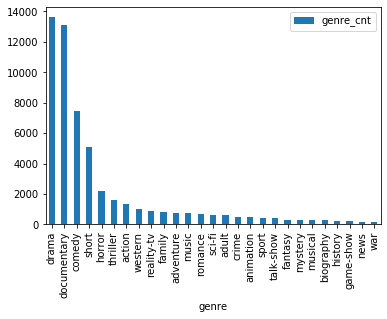

In [5]:
# Посмотрим распределение по жанрам

genre_count_df = train_df[['id','genre']].groupby('genre').agg('count').sort_values('id', ascending = False)

genre_count_df.reset_index(inplace = True)
genre_count_df.rename(columns ={'id':'genre_cnt'}, inplace = True)

genre_count_df.plot.bar(y = 'genre_cnt', x = 'genre')

genre_count_df

Опыты показали, что для нормального обучения сети нужно не меньше 7 000 примеров для каждого жанра, поэтому исключим жанры, для которых есть меньше 7000 примеров

In [8]:
train_df = train_df.merge(genre_count_df, how = 'left', left_on='genre', right_on='genre')

train_df

,id,title,genre,description,genre_cnt
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,13613
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,1591
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,590
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,13613
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,13613
...,...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...,7447
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...,2204
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr...",13096
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...,7447


In [9]:
# Уберем редко встречающиеся варианты

GENRE_CNT_MIN = 7000

train_df = train_df [train_df['genre_cnt'] > GENRE_CNT_MIN]

train_df

,id,title,genre,description,genre_cnt
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,13613
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,13613
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,13613
5,6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm s...,13096
6,7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all ...,7447
...,...,...,...,...,...
54205,54206,Counting Sheep (2004),documentary,Bighorn sheep once roamed the Sierra Nevada in...,13096
54207,54208,Kaçamak (1988),drama,A man and woman meet during the identification...,13613
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...,7447
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr...",13096


In [10]:
#Загружаем тестовые данные

test_df = load_movie_data ('data/test_data_solution.txt')

test_df

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Dar..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their ...
54197,54198,Oliver Twink (2007),adult,"A movie 169 years in the making. Oliver Twist,..."
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ..."


In [11]:
test_df = test_df.merge(genre_count_df, how = 'left', left_on='genre', right_on='genre')

test_df

,id,title,genre,description,genre_cnt
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart...",1591
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi...",7447
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...,13096
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his...",13613
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...,13613
...,...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Dar...",2204
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their ...,1032
54197,54198,Oliver Twink (2007),adult,"A movie 169 years in the making. Oliver Twist,...",590
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ...",13613


In [12]:
test_df = test_df [test_df['genre_cnt'] > GENRE_CNT_MIN]

test_df

,id,title,genre,description,genre_cnt
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi...",7447
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...,13096
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his...",13613
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...,13613
6,7,L'amica (1969),drama,The beautiful but neglected wife of a brillian...,13613
...,...,...,...,...,...
54190,54191,"""House Invaders"" (1998)",documentary,House Invaders features a different home each ...,13096
54191,54192,Eduardo Ducay. El cine que siempre estuvo ahí ...,documentary,Visual documentary about the figure of produce...,13096
54192,54193,Dinosaurs Decoded (2009),documentary,National Geographic reviews Jack Horner's rese...,13096
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ...",13613


## 2. Подготовка данных для модели


In [13]:
def tokenize_text (p_raw_text, p_stop_words):
    '''Функция для токенизации текста

    :param p_raw_text: исходная текстовая строка
    :param p_stop_words: список стоп слов
    '''
    
    tokenized_str = nltk.word_tokenize(p_raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in p_stop_words )]
    
    return filtered_tokens

#tokenize_text

In [14]:
#разбиваем описание на токены

train_df['description_tokenized'] = train_df['description'].apply(lambda x:tokenize_text(x, stopwords.words('english')))
test_df['description_tokenized'] = test_df['description'].apply(lambda x:tokenize_text(x, stopwords.words('english')))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
# создаем словарь

#словарь, составленный из описаний фильмов <word>:<id>
vocabulary = {}

max_val = 1000000

#добавляем зарезервированные слова
vocabulary["<PAD>"] = max_val + 2
vocabulary["<START>"] = max_val + 1
vocabulary["<UNKNOWN>"] = max_val

#посчитаем слова
for tokens in train_df.description_tokenized:
    for word in tokens:
        if word not in vocabulary.keys():
            vocabulary[word] = 1
        else:
            vocabulary[word] = vocabulary[word] + 1
            
#отсортируем слова по частоте
vocabulary = {k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1], reverse = True)}

#проиндексируем слова
cnt = 0
for k in vocabulary.keys():
    vocabulary[k] = cnt
    cnt = cnt + 1
#for
       
print('Количестов слов в словаре:',len(vocabulary))
print()
vocabulary

Количестов слов в словаре: 116281



{'<PAD>': 0,
 '<START>': 1,
 '<UNKNOWN>': 2,
 "'s": 3,
 'life': 4,
 "''": 5,
 '``': 6,
 'one': 7,
 'film': 8,
 'new': 9,
 'world': 10,
 'story': 11,
 'family': 12,
 'young': 13,
 'love': 14,
 'two': 15,
 'years': 16,
 'people': 17,
 'man': 18,
 'time': 19,
 'documentary': 20,
 'lives': 21,
 'father': 22,
 "n't": 23,
 'first': 24,
 'also': 25,
 'get': 26,
 'home': 27,
 'mother': 28,
 'day': 29,
 'find': 30,
 'way': 31,
 'old': 32,
 'back': 33,
 'woman': 34,
 'make': 35,
 'son': 36,
 'wife': 37,
 'work': 38,
 'friends': 39,
 '...': 40,
 'school': 41,
 'city': 42,
 'many': 43,
 'girl': 44,
 'takes': 45,
 'take': 46,
 'three': 47,
 'like': 48,
 'women': 49,
 'finds': 50,
 'journey': 51,
 'daughter': 52,
 'even': 53,
 'friend': 54,
 'together': 55,
 'children': 56,
 'live': 57,
 'war': 58,
 'help': 59,
 'go': 60,
 'town': 61,
 'year': 62,
 'around': 63,
 'become': 64,
 'death': 65,
 'living': 66,
 'house': 67,
 'place': 68,
 'history': 69,
 'us': 70,
 'show': 71,
 'gets': 72,
 'money': 73,


In [18]:
#создаем облегченный словарь для обучения
vocab_light = {}
for k, v in vocabulary.items():
    if v < 10000:
        vocab_light[k] = v

vocab_light

{'<PAD>': 0,
 '<START>': 1,
 '<UNKNOWN>': 2,
 "'s": 3,
 'life': 4,
 "''": 5,
 '``': 6,
 'one': 7,
 'film': 8,
 'new': 9,
 'world': 10,
 'story': 11,
 'family': 12,
 'young': 13,
 'love': 14,
 'two': 15,
 'years': 16,
 'people': 17,
 'man': 18,
 'time': 19,
 'documentary': 20,
 'lives': 21,
 'father': 22,
 "n't": 23,
 'first': 24,
 'also': 25,
 'get': 26,
 'home': 27,
 'mother': 28,
 'day': 29,
 'find': 30,
 'way': 31,
 'old': 32,
 'back': 33,
 'woman': 34,
 'make': 35,
 'son': 36,
 'wife': 37,
 'work': 38,
 'friends': 39,
 '...': 40,
 'school': 41,
 'city': 42,
 'many': 43,
 'girl': 44,
 'takes': 45,
 'take': 46,
 'three': 47,
 'like': 48,
 'women': 49,
 'finds': 50,
 'journey': 51,
 'daughter': 52,
 'even': 53,
 'friend': 54,
 'together': 55,
 'children': 56,
 'live': 57,
 'war': 58,
 'help': 59,
 'go': 60,
 'town': 61,
 'year': 62,
 'around': 63,
 'become': 64,
 'death': 65,
 'living': 66,
 'house': 67,
 'place': 68,
 'history': 69,
 'us': 70,
 'show': 71,
 'gets': 72,
 'money': 73,


In [19]:
#описываем функции кодирования/декодирования слов

def encode_tokens (p_tokens, p_vocabulary):
    '''Кодирования токенов (слов) в индексы словаря
    
    :param p_tokens: список токенов
    :param p_vocabulary: словарь <word>:<id>, c обязательными значениями {<PAD>:0, <START>:1, <UNKNOWN>: 2}
    '''
    res = []
     
    res = [p_vocabulary.get(word, p_vocabulary['<UNKNOWN>']) for word in p_tokens]
    
    return [p_vocabulary['<START>']] + res

#encode_tokens

def dencode_tokens (p_encoded_tokens, p_vocabulary):
    '''Декодирование токенов: индексы словаря -> в тоекны (слова)
    
    :p_encoded_tokens: список индексов словаря
    :param p_vocabulary: словарь <word>:<id>, c обязательными значениями {<PAD>:0, <START>:1, <UNKNOWN>: 2}
    '''
    
    res = []
    
    for index in p_encoded_tokens: 
        for word, v_index in p_vocabulary.items():
            if index == v_index:
                res.append(word)
                break
            #if
    
    return res
    
#dencode_tokens

#!!! проверка
#d_id = 11
#print(train_df.description_tokenized[d_id])
#print()
#encoded_tokens = encode_tokens (train_df.description_tokenized[d_id], vocabulary)
#print (encoded_tokens)
#print()
#print (dencode_tokens (encoded_tokens, vocabulary))


In [20]:
#кодируем описание фильмов

train_df['description_encoded'] = train_df['description_tokenized'].apply(lambda x: encode_tokens (x, vocab_light))

train_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,title,genre,description,genre_cnt,description_tokenized,description_encoded
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,13613,"[listening, conversation, doctor, parents, 10-...","[1, 5031, 1922, 349, 113, 8047, 2411, 348, 203..."
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,13613,"[help, unemployed, father, make, ends, meet, e...","[1, 59, 2047, 22, 35, 402, 130, 5367, 2062, 16..."
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,13613,"[film, 's, title, refers, un-recovered, bodies...","[1, 8, 3, 1093, 5521, 2, 1691, 1235, 4747, 25,..."
5,6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm s...,13096,"[quality, control, consists, series, 16mm, sin...","[1, 2567, 431, 3891, 77, 7568, 399, 46, 3265, ..."
6,7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all ...,7447,"[tough, economic, times, max, joey, run, ideas...","[1, 1513, 792, 281, 1205, 4748, 258, 1024, 263..."
...,...,...,...,...,...,...,...
54205,54206,Counting Sheep (2004),documentary,Bighorn sheep once roamed the Sierra Nevada in...,13096,"[bighorn, sheep, roamed, sierra, nevada, great...","[1, 2, 4801, 2, 6355, 8279, 136, 3287, 2448, 1..."
54207,54208,Kaçamak (1988),drama,A man and woman meet during the identification...,13613,"[man, woman, meet, identification, spouses, de...","[1, 18, 34, 130, 2, 9048, 312, 1691, 311, 250,..."
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...,7447,"[short-lived, nbc, live, sitcom, centered, bon...","[1, 7663, 9914, 57, 4214, 4770, 2, 7301, 1632,..."
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr...",13096,"[ze, bestaan, echt, stand-up, comedy, growing,...","[1, 2, 2, 2, 3247, 152, 528, 934, 1157, 2, 730..."


In [21]:
test_df['description_encoded'] = test_df['description_tokenized'].apply(lambda x: encode_tokens (x, vocab_light))

test_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,title,genre,description,genre_cnt,description_tokenized,description_encoded
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi...",7447,"[spain, march, 1964, quico, naughty, child, th...","[1, 1474, 1798, 6126, 2, 2, 128, 47, 4089, 429..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...,13096,"[one, year, life, albin, family, shepherds, no...","[1, 7, 62, 4, 2, 12, 2, 383, 2, 2324, 707, 727..."
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his...",13613,"[father, died, n't, spoken, brother, 10, years...","[1, 22, 484, 23, 4479, 112, 941, 16, 990, 818,..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...,13613,"[known, internationally, martial, arts, supers...","[1, 202, 4164, 3775, 1182, 3713, 3397, 866, 34..."
6,7,L'amica (1969),drama,The beautiful but neglected wife of a brillian...,13613,"[beautiful, neglected, wife, brilliant, archit...","[1, 185, 3411, 37, 1977, 1999, 4342, 4462, 80,..."
...,...,...,...,...,...,...,...
54190,54191,"""House Invaders"" (1998)",documentary,House Invaders features a different home each ...,13096,"[house, invaders, features, different, home, e...","[1, 67, 2, 514, 88, 27, 684, 1981, 187, 15, 2,..."
54191,54192,Eduardo Ducay. El cine que siempre estuvo ahí ...,documentary,Visual documentary about the figure of produce...,13096,"[visual, documentary, figure, producer, eduard...","[1, 1473, 20, 959, 867, 7178, 2, 4994, 458, 19..."
54192,54193,Dinosaurs Decoded (2009),documentary,National Geographic reviews Jack Horner's rese...,13096,"[national, geographic, reviews, jack, horner, ...","[1, 309, 7501, 5266, 538, 2, 3, 835, 4447, 2, ..."
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ...",13613,"[popular, mysterious, rock, d.j, mike, mallard...","[1, 425, 449, 419, 2, 942, 2, 2, 8980, 71, 155..."


In [22]:
#Готовим данные для обучения
train_data = train_df.description_encoded.to_numpy()
train_labels = pd.get_dummies(train_df['genre']).values

test_data = test_df.description_encoded.to_numpy()
test_labels = pd.get_dummies(test_df['genre']).values


минимальная длина описания: 5
средняя длина описания: 62
максимальная длина описания: 1482


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([6.47473304e-03, 2.68591210e-04, 2.20026747e-05, 3.76622360e-06,
        7.92889180e-07, 0.00000000e+00, 0.00000000e+00, 3.96444590e-07,
        0.00000000e+00, 1.98222295e-07]),
 array([   5. ,  152.7,  300.4,  448.1,  595.8,  743.5,  891.2, 1038.9,
        1186.6, 1334.3, 1482. ]),
 <a list of 10 Patch objects>)

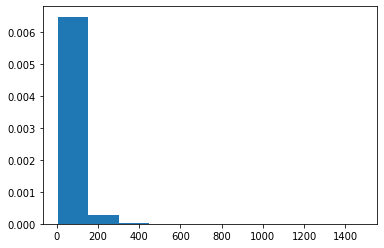

In [23]:
# Посчитаем среднюю длинну описания, чтобы определить длинну последовательности
train_df['description_len'] = train_df['description_encoded'].apply (len)

print ('минимальная длина описания:', train_df.description_len.min())
print ('средняя длина описания:', round(train_df.description_len.mean()))
print ('максимальная длина описания:', train_df.description_len.max())

plt.hist(train_df.description_len, density = True)

In [24]:
# Приведем все цепочки в датасете к одной длине с помощью паддинга

MAX_SEQ_LEN = 70

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value= vocabulary['<PAD>'],
    padding= 'post',
    maxlen= MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value= vocabulary['<PAD>'],
    padding= 'post',
    maxlen= MAX_SEQ_LEN)

print('Тернировочные данные:')
print(train_data.shape)
print(train_data[0])
print()
print('Тестовые данные:')
print(test_data.shape)
print(test_data[0])

Тернировочные данные:
(34156, 70)
[   1 5031 1922  349  113 8047 2411  348 2036 1170  308 1014   57 4072
  766 1131  779 1772    2 1231  746 4583  107  376    2 1039 2462 1231
  861    2  396  606 8048 1906 4912 3099 1639 2411   57    4   14  328
  194   39 1358    2    2    2  323 2984 7011 1627    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

Тестовые данные:
(34154, 70)
[   2    2  128   47 4089  429 4989   12  148 8944    3  521  554  161
 5583 1240    6 1385    5   67 1190  377   32  165  112 2650 1190   16
   32  842    2  660   19 5075 8821 8821 2339 2177 1689   28 5112   32
    2  713   12  276   15  122  583  427    2   28    2   22 9254 1024
   43   16 1394  762   58    2 3623 1416   56    6  927    3   58    5]


In [25]:
#Разбьем обучающий датасет на обучающий и валидационный

partial_x_train, x_val, partial_y_train, y_val = train_test_split(train_data, train_labels, 
                                                                  test_size = 0.10, random_state = 42)

print(partial_x_train.shape, partial_y_train.shape)
print(x_val.shape, y_val.shape)

(30740, 70) (30740, 3)
(3416, 70) (3416, 3)


## 3. Создание и обучение модели

In [31]:
# Создадим рекурентную модель для классификации

VOCAB_SIZE = len(vocab_light)
# Размер векторного представления (эмбеддинга)
EMB_SIZE = 32
# Количество классов (жанров фильмов)
CLASS_NUM = y_val.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(CLASS_NUM, activation= 'softmax'),
])

#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE, input_length=train_data.shape[1]),
#    tf.keras.layers.SpatialDropout1D(0.2),
#    tf.keras.layers.LSTM(EMB_SIZE, dropout=0.2, recurrent_dropout=0.2),
#    tf.keras.layers.Dense(CLASS_NUM, activation= 'softmax'),
#])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 361,667
Trainable params: 361,667
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Обучение модели
BATCH_SIZE = 64
NUM_EPOCHS = 5

#Настраиваем объект для сохранения результатов работы модели
cpt_path = 'data/14_text_classifier.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='acc', verbose=1, save_best_only= True, mode='max')

model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['acc'])

#запускаем обучение
history= model.fit(partial_x_train, partial_y_train, validation_data= (x_val, y_val), 
                   epochs= NUM_EPOCHS, batch_size= BATCH_SIZE, verbose= 1,
                   callbacks=[checkpoint])


Epoch 1/5
481/481 [==============================] - ETA: 0s - loss: 0.6928 - acc: 0.6827
Epoch 00001: acc improved from -inf to 0.68266, saving model to data/14_text_classifier.hdf5
481/481 [==============================] - 48s 99ms/step - loss: 0.6928 - acc: 0.6827 - val_loss: 0.5127 - val_acc: 0.7881
Epoch 2/5
481/481 [==============================] - ETA: 0s - loss: 0.4468 - acc: 0.8214
Epoch 00002: acc improved from 0.68266 to 0.82137, saving model to data/14_text_classifier.hdf5
481/481 [==============================] - 52s 109ms/step - loss: 0.4468 - acc: 0.8214 - val_loss: 0.5085 - val_acc: 0.8033
Epoch 3/5
481/481 [==============================] - ETA: 0s - loss: 0.3659 - acc: 0.8596
Epoch 00003: acc improved from 0.82137 to 0.85956, saving model to data/14_text_classifier.hdf5
481/481 [==============================] - 51s 107ms/step - loss: 0.3659 - acc: 0.8596 - val_loss: 0.5186 - val_acc: 0.8006
Epoch 4/5
481/481 [==============================] - ETA: 0s - loss: 0.320

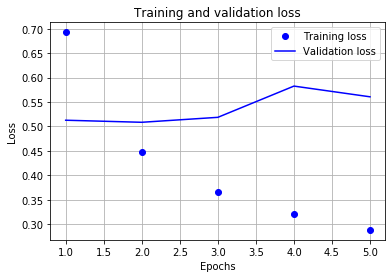

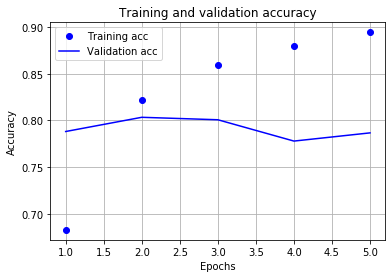

In [33]:
#отобразим графики обучения

epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [34]:
# оценим качество на тестовом датасете

results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1068/1068 [==============================] - 18s 17ms/step - loss: 0.5838 - acc: 0.7789
Test loss: 0.5838
Test accuracy: 77.89 %
